# Baixando as bibliotecas

In [1]:
!pip install mlforecast dill

# Importando as bibliotecas

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import dill as pickle

import mlforecast
from mlforecast import MLForecast
from utilsforecast.losses import mae, mape, rmse, smape
from utilsforecast.evaluation import evaluate
from utilsforecast.plotting import plot_series


from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

from mlforecast.auto import (
    AutoLightGBM,
    AutoMLForecast,
    AutoModel,
    AutoRidge,
    ridge_space,
    AutoRandomForest,
    AutoXGBoost,
    AutoLinearRegression,
    AutoLasso,
    AutoElasticNet,
    AutoCatboost,
    xgboost_space,
    catboost_space,
    random_forest_space
)

import warnings
warnings.filterwarnings('ignore')

# Funcoes

In [3]:
def mean_absolute_percentage_error(y_true, y_pred):
      y_true, y_pred = np.array(y_true), np.array(y_pred)
      non_zero_idx = y_true != 0
      return np.mean(np.abs((y_true[non_zero_idx] - y_pred[non_zero_idx]) / y_true[non_zero_idx])) * 100

# Carregando os dados

In [4]:
bucket_uri = "gs://m5_dados/M5_full.parquet"

In [5]:
dados = pd.read_parquet(bucket_uri)

In [6]:
dados['date'] = pd.to_datetime(dados['date'])

In [8]:
dados.set_index('date', inplace=True)

# Criando série temporal de todos os produtos

In [10]:
produtos = dados.groupby(['id']).resample('MS')['value'].sum()

## Série temporal do top 100 produtos

In [11]:
top_100_produtos = produtos.groupby('id').sum().nlargest(100).index

In [12]:
produtos = produtos[produtos.index.get_level_values('id').isin(top_100_produtos)]

# Divisão entre treino e teste com previsão de 6 meses

In [13]:
teste_size = 6
teste = produtos.groupby(['id']).tail(teste_size)
train = produtos.drop(teste.index)

# Transformando o DataFrame para o padrão Nixtla

In [14]:
df_train = train.reset_index()
df_test = teste.reset_index()

In [15]:
df_train = df_train.rename(columns={'date': 'ds',
                                    'value': 'y',
                                    'id': 'unique_id'})

df_test = df_test.rename(columns={'date': 'ds',
                                  'value': 'y',
                                  'id': 'unique_id'})

## Procurando o melhor modelo para a previsão

In [16]:
models={
        'lgb': AutoLightGBM(),
         'rf' : AutoRandomForest(),
         'xgb' : AutoXGBoost(),
         'linear' : AutoLinearRegression()
        }

In [17]:
auto_mlf = AutoMLForecast(
    models=models,
    freq="MS",
    season_length=12,
)

In [18]:
auto_mlf.fit(
    df_train,
    n_windows=6,
    h=6,
    num_samples=8,
)

[I 2024-07-05 17:02:19,975] A new study created in memory with name: no-name-bbb821c8-2792-438c-ad13-1ae9ba7dba13
[I 2024-07-05 17:02:20,596] Trial 0 finished with value: 0.20954886692215344 and parameters: {'n_estimators': 169, 'lambda_l1': 0.027334069690310565, 'lambda_l2': 0.0026599310838681858, 'num_leaves': 112, 'feature_fraction': 0.7118273996694524, 'bagging_fraction': 0.8229470565333281, 'objective': 'l2', 'target_transforms_idx': 0, 'lags_idx': 0, 'lag_transforms_idx': 3, 'use_date_features': 1}. Best is trial 0 with value: 0.20954886692215344.
[I 2024-07-05 17:02:21,090] Trial 1 finished with value: 0.22518576681613922 and parameters: {'n_estimators': 454, 'lambda_l1': 0.00014233583723829364, 'lambda_l2': 0.10586748269028218, 'num_leaves': 4, 'feature_fraction': 0.819960510663762, 'bagging_fraction': 0.5716766437045232, 'objective': 'l1', 'target_transforms_idx': 2, 'lags_idx': 1, 'lag_transforms_idx': 1, 'use_date_features': 0}. Best is trial 0 with value: 0.2095488669221534

AutoMLForecast(models={'lgb': AutoModel(model=LGBMRegressor), 'rf': AutoModel(model=RandomForestRegressor), 'xgb': AutoModel(model=XGBRegressor), 'linear': AutoModel(model=LinearRegression)})

In [19]:
for model_name, result in auto_mlf.results_.items():
    best_params = result.best_trial.user_attrs['config']
    print(f"Best parameters for {model_name}:")
    print(best_params)
    print("\n")

Best parameters for lgb:
{'model_params': {'bagging_freq': 1, 'learning_rate': 0.05, 'verbosity': -1, 'n_estimators': 729, 'lambda_l1': 0.026802277287262158, 'lambda_l2': 9.763894071534004, 'num_leaves': 5, 'feature_fraction': 0.9340630286841072, 'bagging_fraction': 0.5812464673381874, 'objective': 'l1'}, 'mlf_init_params': {'lags': range(1, 13), 'target_transforms': None, 'lag_transforms': {1: [ExponentiallyWeightedMean(alpha=0.9)]}, 'date_features': None, 'num_threads': 1}, 'mlf_fit_params': {}}


Best parameters for rf:
{'model_params': {'n_estimators': 933, 'max_depth': 7, 'min_samples_split': 79, 'max_features': 0.6408650528769746, 'criterion': 'squared_error'}, 'mlf_init_params': {'lags': [12], 'target_transforms': [<mlforecast.target_transforms.LocalStandardScaler object at 0x7fa4d26c8d00>], 'lag_transforms': {1: [ExponentiallyWeightedMean(alpha=0.9)], 12: [RollingMean(min_samples=1, window_size=12)]}, 'date_features': ['month', 'year'], 'num_threads': 1}, 'mlf_fit_params': {}}


In [20]:
preds = auto_mlf.predict(6)

In [21]:
for i in list(models.keys()):
  preds[i] = preds[i].astype(int)

## Analisando o resultado dos modelos por gráficos

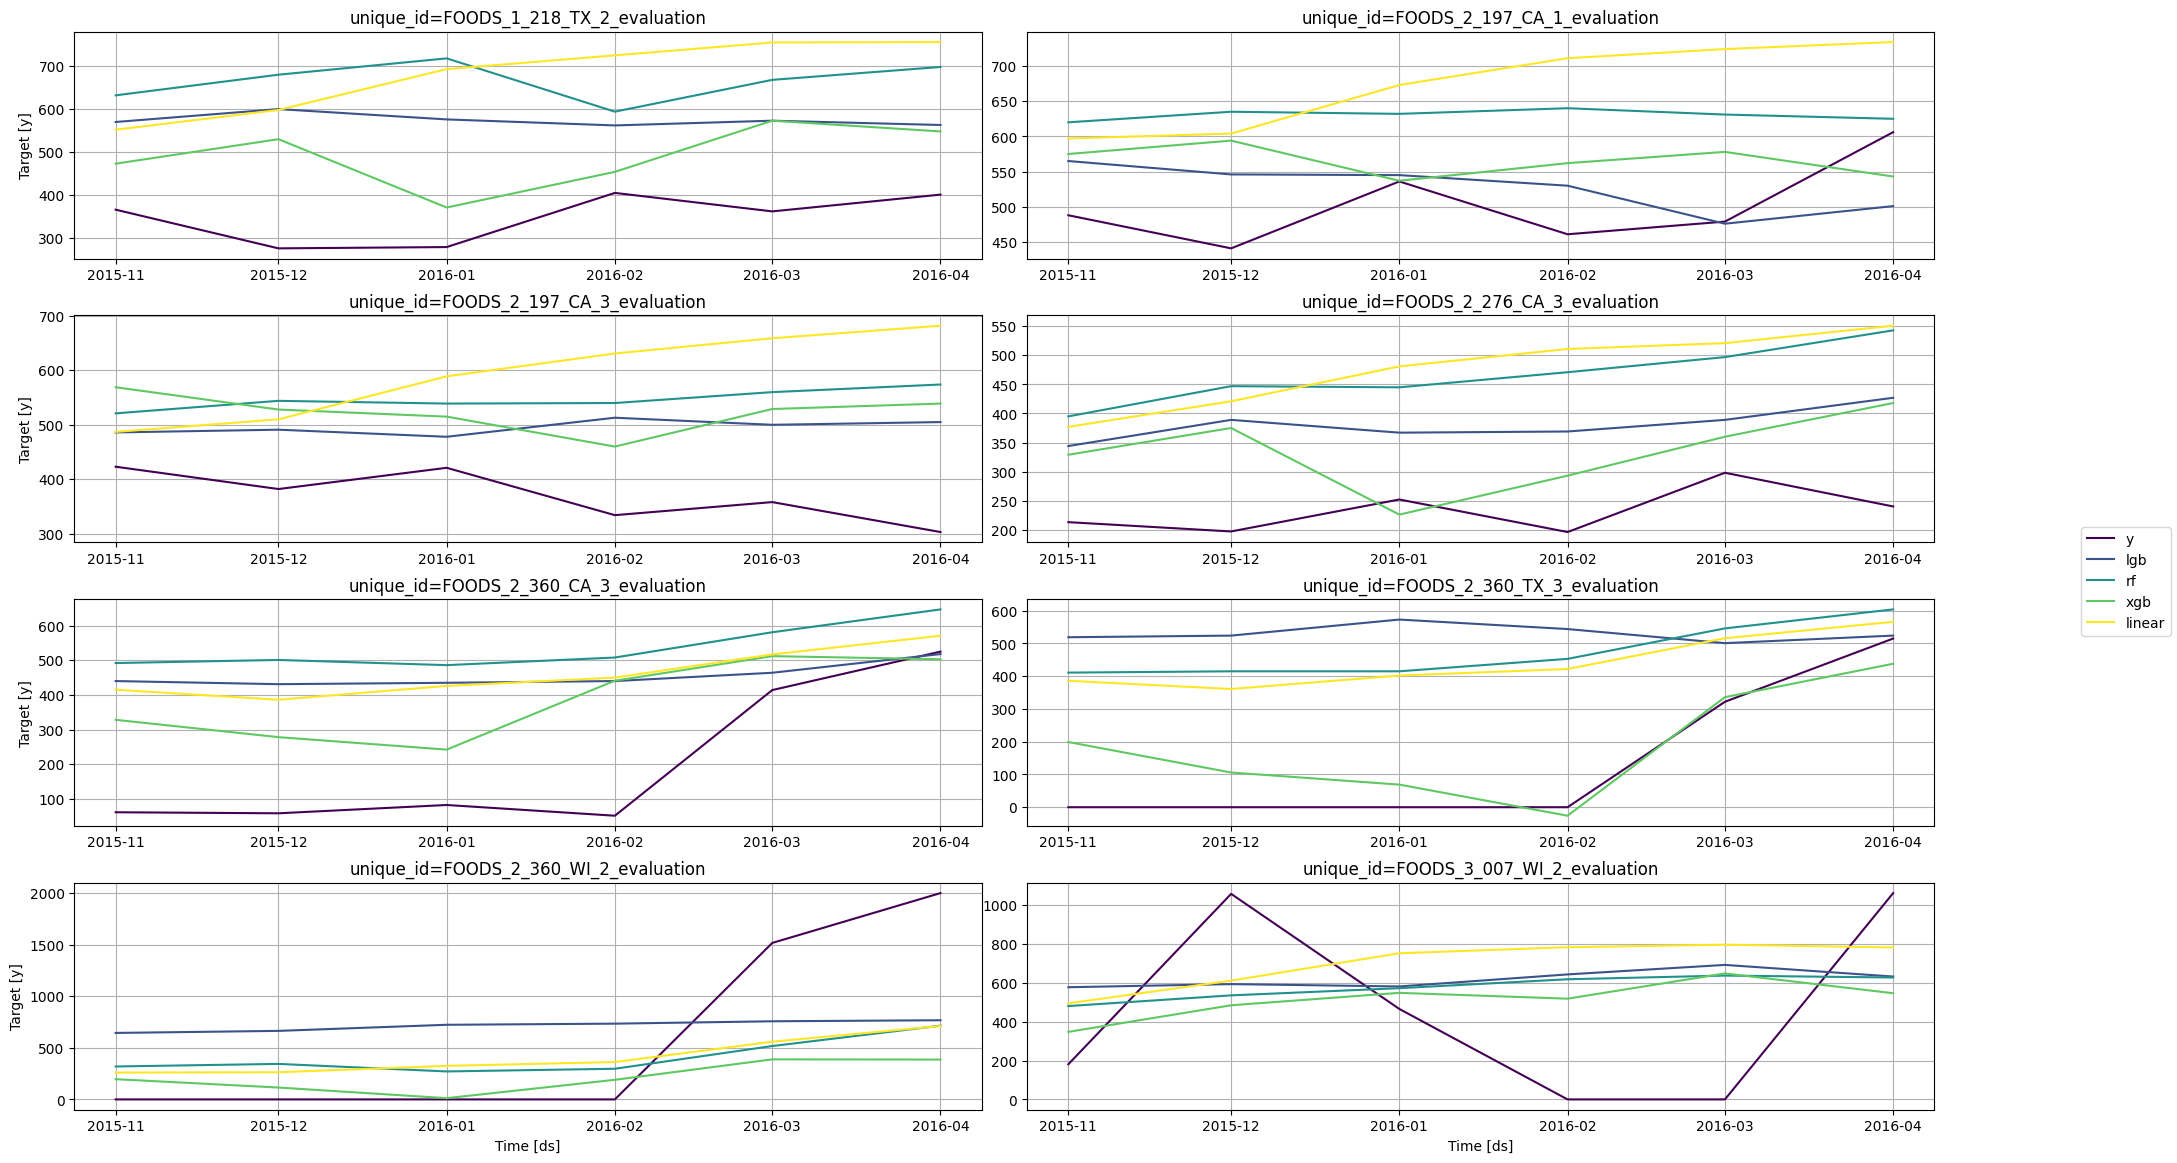

In [22]:
plot_series(df_test, preds, plot_random=False)

## Validando as métricas

In [23]:
previsao_full = df_test.merge(preds, how='right', on=['unique_id', 'ds'])

In [24]:
for i in list(models.keys()):
  print(f'------------------{i}-----------------')
  MAE = mean_absolute_error(df_test['y'], previsao_full[i])
  print(f'Mean Absolute Error: {MAE}')

  MAPE = mean_absolute_percentage_error(df_test['y'], previsao_full[i])
  print(f'Mean absolute percentage error: {MAPE}')

  RMSE = sqrt(mean_squared_error(previsao_full[i], df_test['y']))
  print(f'Root mean squared error: {RMSE}')

  R2 = r2_score(df_test['y'], previsao_full[i])
  print(f'R2: {R2}')
  print('\n')

------------------lgb-----------------
Mean Absolute Error: 225.085
Mean absolute percentage error: 270.2527558056013
Root mean squared error: 341.2507753348945
R2: 0.6553588717554308


------------------rf-----------------
Mean Absolute Error: 236.09666666666666
Mean absolute percentage error: 299.52445753384234
Root mean squared error: 361.3363253258659
R2: 0.6135947156839571


------------------xgb-----------------
Mean Absolute Error: 236.10833333333332
Mean absolute percentage error: 245.03951377806015
Root mean squared error: 361.4815739886797
R2: 0.6132840016629837


------------------linear-----------------
Mean Absolute Error: 230.195
Mean absolute percentage error: 257.3573460591361
Root mean squared error: 337.01413175117744
R2: 0.6638632210025082




## Analisando o desempenho do melhor modelo

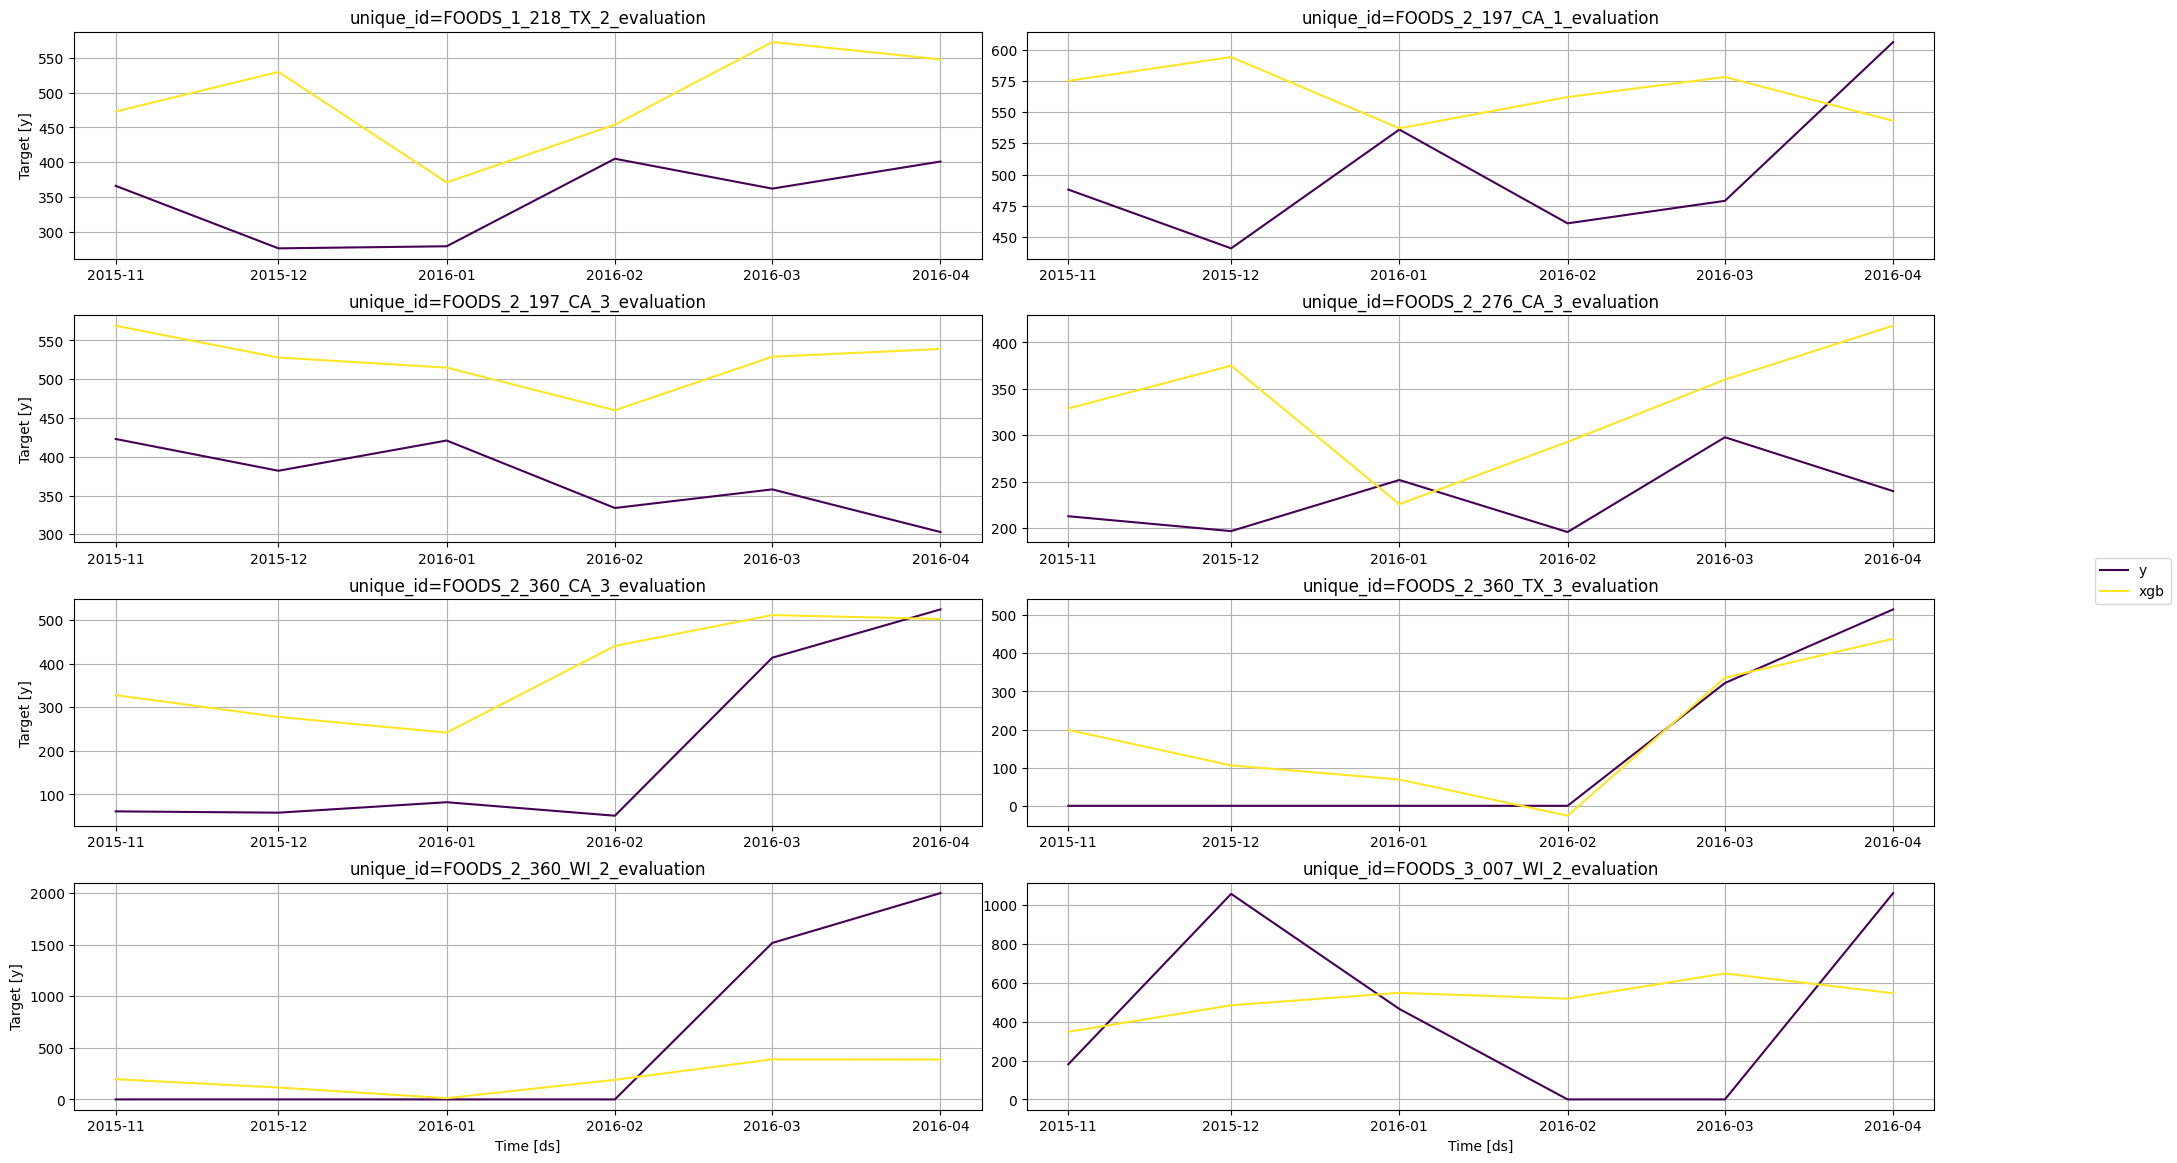

In [25]:
plot_series(df_test, preds[['unique_id', 'ds', 'xgb']], plot_random=False)

In [26]:
tabela_validacao = previsao_full[['unique_id', 'ds', 'y', 'xgb']]

## Previsão dos próximos 6 meses

In [27]:
models={
         'xgb' : AutoXGBoost()
        }

In [28]:
dados_full = pd.concat([df_train, df_test])

In [29]:
auto_mlf_full = AutoMLForecast(
    models=models,
    freq="MS",
    season_length=12,
)

In [30]:
auto_mlf_full.fit(
    df_train,
    n_windows=6,
    h=6,
    num_samples=8,
)

[I 2024-07-05 17:03:22,645] A new study created in memory with name: no-name-8f24aaea-c41a-44d3-9d66-d5aaab20e852
[I 2024-07-05 17:03:24,415] Trial 0 finished with value: 0.3906177580356598 and parameters: {'n_estimators': 558, 'max_depth': 8, 'learning_rate': 0.024376795198947098, 'subsample': 0.5903948646972071, 'bagging_freq': 0.4812893194050143, 'colsample_bytree': 0.6813047017599905, 'min_data_in_leaf': 44.321133915006556, 'reg_lambda': 0.13620216352659412, 'reg_alpha': 0.5120378720005675, 'min_child_weight': 5, 'target_transforms_idx': 3, 'lags_idx': 2, 'lag_transforms_idx': 2, 'use_date_features': 0}. Best is trial 0 with value: 0.3906177580356598.
[I 2024-07-05 17:03:25,081] Trial 1 finished with value: 0.22102732956409454 and parameters: {'n_estimators': 785, 'max_depth': 2, 'learning_rate': 0.02968092728356274, 'subsample': 0.22901795866814179, 'bagging_freq': 0.9502020253446255, 'colsample_bytree': 0.5696634895750645, 'min_data_in_leaf': 42.051532059061834, 'reg_lambda': 1.3

AutoMLForecast(models={'xgb': AutoModel(model=XGBRegressor)})

In [31]:
preds = auto_mlf_full.predict(6)

In [32]:
for i in list(models.keys()):
  preds[i] = preds[i].astype(int)

# Exportando os arquivos

# Exportando o pickle

In [33]:
with open('ModelosPKL/produtos.pkl', 'wb') as f:
     pickle.dump(auto_mlf_full, f)

# Previsão futuro

In [34]:
preds.to_csv('previsao_produtos.csv', index=False)

# Validação

In [35]:
tabela_validacao.to_csv('validacao_produtos.csv', index=False)